#Self_SL 과제

##1. 라이브러리 임포트 및 시드 설정

- 재현성을 위한 시드 설정

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import random
from itertools import cycle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if device.type == 'cuda':
    torch.cuda.manual_seed(seed)

Using device: cuda


##2. 데이터 전처리 및 데이터셋 다운로드, labeld / unlabeled 분할

- 데이터 전처리
  - augmentation 및 normalization

- 각 클래스당 60장만 labeled로 선택해서 분할
  - Labeled data : 6000개
  - Unlabeled data : 44000개

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761])
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761])
])

full_train = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
test_set   = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)

labeled_idx = []
targets = np.array(full_train.targets)
num_classes = 100
num_labels_per_class = 60

for c in range(num_classes):
    class_idx = np.where(targets == c)[0]
    selected = np.random.choice(class_idx, num_labels_per_class, replace=False)
    labeled_idx.extend(selected)
labeled_idx = np.array(labeled_idx)
unlabeled_idx = np.setdiff1d(np.arange(len(full_train)), labeled_idx)

print("Labeled data:", len(labeled_idx))
print("Unlabeled data:", len(unlabeled_idx))

labeled_dataset = Subset(full_train, labeled_idx)
unlabeled_dataset = Subset(full_train, unlabeled_idx)

Labeled data: 6000
Unlabeled data: 44000


##3. DataLoader 구성

- batch_size 128

In [ ]:
batch_size = 128
labeled_loader   = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader      = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

##4. 모델 정의

- CIFAR100 데이터셋에 맞게 수정한 ResNet18

- 첫 convolution layer 및 maxpool 제거

In [ ]:
def get_resnet18(num_classes=100):
    model = torchvision.models.resnet18(pretrained=False)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

##5. 평가 함수 정의

In [ ]:
def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100.0 * correct / total
    return acc

##6. Baseline 모델 학습 함수 정의

- 각 클래스당 60장의 레이블(전체의 10%)만 사용한 Supervised Learning

In [ ]:
def train_baseline(model, loader, optimizer, criterion, num_epochs):
    model.train()
    test_acc_list = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(loader.dataset)
        acc = evaluate(model, test_loader)
        test_acc_list.append(acc)
        print(f'Baseline Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Test Acc: {acc:.2f}%')
    return model, test_acc_list

##7. Semi_Supervised 모델 학습 함수 정의

- 전체 데이터(레이블 10% + unlabeled 90%)를 활용하며, unlabeled 데이터에 대해 Self-SL (pseudo-labeling) 방법을 적용

- pseudo-labeling이란 모델의 현재 예측값에서 최고 확률(class 확률이 threshold 이상인 경우)을 pseudo label로 사용하여 loss에 반영하는 것임

In [ ]:
def train_semi_supervised(model, labeled_loader, unlabeled_loader, optimizer, criterion, num_epochs, lambda_u=1.0, threshold=0.95):
    model.train()
    test_acc_list = []
    unlabeled_cycle = cycle(unlabeled_loader)
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images_l, labels in labeled_loader:
            images_l, labels = images_l.to(device), labels.to(device)
            images_ul, _ = next(unlabeled_cycle)
            images_ul = images_ul.to(device)

            optimizer.zero_grad()
            outputs_l = model(images_l)
            loss_l = criterion(outputs_l, labels)

            outputs_ul = model(images_ul)
            probs_ul = torch.softmax(outputs_ul, dim=1)
            max_probs, pseudo_labels = torch.max(probs_ul, dim=1)
            mask = max_probs.ge(threshold).float()
            if mask.sum() > 0:
                loss_u = (criterion(outputs_ul, pseudo_labels) * mask).mean()
            else:
                loss_u = 0.0

            loss = loss_l + lambda_u * loss_u
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images_l.size(0)
        epoch_loss = running_loss / len(labeled_loader.dataset)
        acc = evaluate(model, test_loader)
        test_acc_list.append(acc)
        print(f'Semi-Supervised Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Test Acc: {acc:.2f}%')
    return model, test_acc_list

##8. 하이퍼파라미터 설정 및 학습 실행

In [ ]:
num_epochs_baseline = 50
num_epochs_semi = 50
learning_rate = 0.1
criterion = nn.CrossEntropyLoss()

print("Training Baseline Model (Supervised only on labeled data)...")
baseline_model = get_resnet18().to(device)
optimizer_baseline = optim.SGD(baseline_model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
baseline_model, baseline_acc_list = train_baseline(baseline_model, labeled_loader, optimizer_baseline, criterion, num_epochs_baseline)
baseline_acc = evaluate(baseline_model, test_loader)
print(f'\nBaseline Model Final Test Accuracy: {baseline_acc:.2f}%')

print("\nTraining Semi-Supervised Model (Using Self-SL with unlabeled data)...")
semi_model = get_resnet18().to(device)
optimizer_semi = optim.SGD(semi_model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
semi_model, semi_acc_list = train_semi_supervised(semi_model, labeled_loader, unlabeled_loader, optimizer_semi, criterion,
                                                  num_epochs_semi, lambda_u=1.0, threshold=0.95)
semi_acc = evaluate(semi_model, test_loader)
print(f'\nSemi-Supervised Model Final Test Accuracy: {semi_acc:.2f}%')

Training Baseline Model (Supervised only on labeled data)...
Baseline Epoch [1/50], Loss: 4.6837, Test Acc: 5.17%
Baseline Epoch [2/50], Loss: 4.6352, Test Acc: 1.00%
Baseline Epoch [3/50], Loss: 4.5999, Test Acc: 1.12%
Baseline Epoch [4/50], Loss: 4.6049, Test Acc: 1.42%
Baseline Epoch [5/50], Loss: 4.5415, Test Acc: 2.65%
Baseline Epoch [6/50], Loss: 4.3502, Test Acc: 4.07%
Baseline Epoch [7/50], Loss: 4.2277, Test Acc: 4.79%
Baseline Epoch [8/50], Loss: 4.1359, Test Acc: 4.66%
Baseline Epoch [9/50], Loss: 4.0838, Test Acc: 6.67%
Baseline Epoch [10/50], Loss: 4.0278, Test Acc: 7.73%
Baseline Epoch [11/50], Loss: 3.9674, Test Acc: 7.28%
Baseline Epoch [12/50], Loss: 3.9318, Test Acc: 8.63%
Baseline Epoch [13/50], Loss: 3.8678, Test Acc: 9.92%
Baseline Epoch [14/50], Loss: 3.8224, Test Acc: 9.71%
Baseline Epoch [15/50], Loss: 3.8028, Test Acc: 11.10%
Baseline Epoch [16/50], Loss: 3.7510, Test Acc: 11.77%
Baseline Epoch [17/50], Loss: 3.7104, Test Acc: 11.65%
Baseline Epoch [18/50], Los

##9. 학습 추세 확인

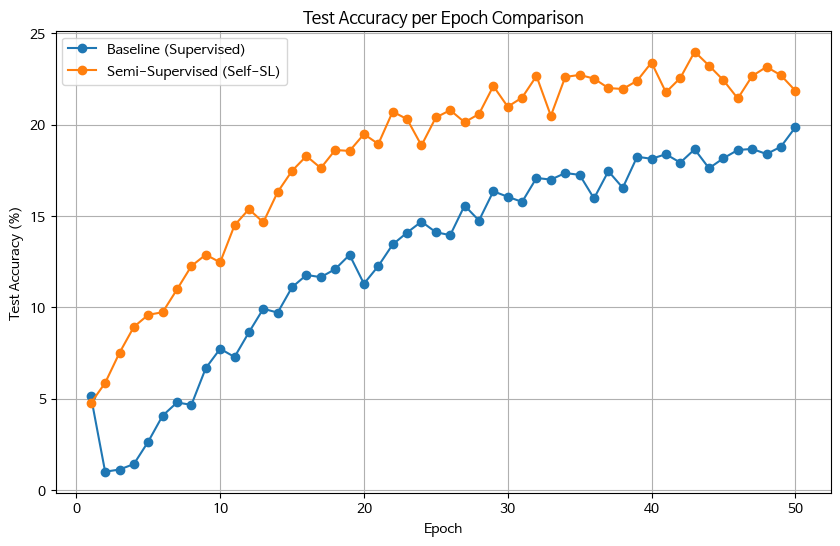

In [ ]:
import matplotlib.pyplot as plt

epochs_baseline = list(range(1, num_epochs_baseline + 1))
epochs_semi = list(range(1, num_epochs_semi + 1))

plt.figure(figsize=(10, 6))
plt.plot(epochs_baseline, baseline_acc_list, marker='o', label='Baseline (Supervised)')
plt.plot(epochs_semi, semi_acc_list, marker='o', label='Semi-Supervised (Self-SL)')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy per Epoch Comparison')
plt.legend()
plt.grid(True)
plt.show()

##어려웠던 점

- 클래스당 60장의 이미지만 라벨로 사용하니 정확도 확보가 어려웠다.

- ResNet18을 CIFAR100 데이터 크기에 맞게 수정하는 것에서 생각보다 조금 해맸다.

##분석 및 고찰

- Baseline 모델은 레이블 10%만을 사용하여 학습하였기 때문에, 상대적으로 낮은 정확도를 보였다고 생각한다.

- Semi-Supervised 모델은 추가로 unlabeled 데이터를 활용하기 때문에 더 높은 정확도가 나온 것 같고, pseudo-label이 잘 작동한 것 같다. 만약 0.95보다 더 이상적인 threshold 값을 찾는다면 성능 향상을 기대할 수 있을 것 같다.